# 1.Feature Extraction

## Loading images

In [ ]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import glob
import time
import cv2
from sklearn.decomposition import PCA
import skimage.measure

#set rand seed
np.random.seed(0)


In [ ]:
#load paths
train_paths = glob.glob('Reduced MNIST Data/Reduced Trainging data/*/*')
test_paths = glob.glob('Reduced MNIST Data/Reduced Testing data/*/*')

In [ ]:
len(train_paths),len(test_paths)

In [ ]:
#load images
train_imgs = np.zeros((10000,28,28))
for i,path in enumerate(train_paths):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    train_imgs[i] = img
    
test_imgs = np.zeros((2000,28,28))
for i,path in enumerate(test_paths):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    test_imgs[i] = img

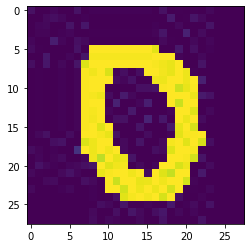

In [6]:
#view a sample
plt.imshow(train_imgs[5]);

## Extracting features

### PCA

In [7]:
#train
pca = PCA(n_components=0.90)
train_pca = pca.fit_transform(train_imgs.reshape(10000,-1))
print("variance = ",pca.explained_variance_ratio_.sum())
print("New number of dimensions = ",train_pca.shape[-1])

variance =  0.9003751809593754
New number of dimensions =  167


In [8]:
#test
startTime = time.time()
test_pca = pca.transform(test_imgs.reshape(2000,-1))
pca_time = time.time() - startTime

### DCT

In [9]:
#get zegzag mask to reduce number of features of DCT
def get_low_freq_zigzag_mask(m,number_of_features):
    a = np.arange(0,m*m).reshape(m,m)
    a_zigzag = np.concatenate([np.diagonal(a[::-1,:], i)[::(2*((i-m%2) % 2)-1)] for i in range(1-m, m)])
    a_zigzag_cut = a_zigzag[:number_of_features]
    mask = np.isin(a,a_zigzag_cut)
    return mask
mask = get_low_freq_zigzag_mask(28,200)

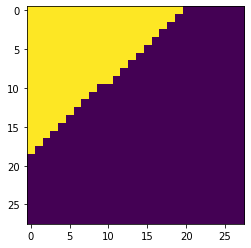

In [10]:
plt.imshow(mask);

In [11]:
#train
train_dct = np.zeros((10000,200))
for i,img in enumerate(train_imgs):
    img_dct = cv2.dct(np.cast['float32'](img))
    features = img_dct[mask] 
    train_dct[i,:] = features

In [12]:
#test
startTime = time.time()

test_dct = np.zeros((2000,200))
for i,img in enumerate(test_imgs):
    img_dct = cv2.dct(np.cast['float32'](img))
    features = img_dct[mask] 
    test_dct[i,:] = features
dct_time = time.time() - startTime

### Pooling images

In [13]:
#train
train_pool = np.zeros((10000,196))
for i,img in enumerate(train_imgs):
    img_pool = skimage.measure.block_reduce(img, (2,2), np.mean)
    train_pool[i,:] = img_pool.reshape(-1)

In [14]:
#test
startTime = time.time()

test_pool = np.zeros((2000,196))
for i,img in enumerate(test_imgs):
    img_pool = skimage.measure.block_reduce(img, (2,2), np.mean)
    test_pool[i,:] = img_pool.reshape(-1)
pool_time = time.time() - startTime

### Edge detection

In [15]:
#train
features_len = []
train_edge = np.zeros((10000,2,200))
for i,path in enumerate(train_paths):
    img = cv2.imread(path)
    canny = cv2.Canny(img,100,200)
    features = list(np.where(canny>0))
    length = features[0].shape[0]
    features_len.append(length)
    train_edge[i,:,:length] = features
    
max_len = max(features_len)
train_edge = train_edge[:,:,:max_len].reshape(10000,-1)

In [16]:
#test
startTime = time.time()

test_edge = np.zeros((2000,2,200))
for i,path in enumerate(test_paths):
    img = cv2.imread(path)
    canny = cv2.Canny(img,100,200)
    features = list(np.where(canny>0))
    length = features[0].shape[0]
    test_edge[i,:,:length] = features
test_edge = test_edge.reshape(2000,-1)
edge_time = time.time() - startTime

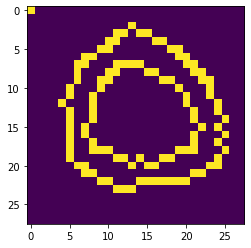

In [17]:
#show a sample 
pts = train_edge[100]
img = np.zeros((28,28))
img[(pts[:max_len].astype('int'),pts[max_len:].astype('int'))] = 255
plt.imshow(img);